In [4]:
import json
import pandas as pd
from collections import Counter
from pylab import plot, loglog
import re

%matplotlib inline

def read_one(line, _split):
    if _split:
        k, v = line.split('\t')
        d = json.loads(v)
        d["key"] = ":".join(k.split('/')[0:2])
    else:
        d = json.loads(line)
    return d


def read_tweets(filename, _split=True):
    X = {"key": [], "text": []}
    with open(filename) as f:
        lineno = 0
        while True:
            lineno += 1
            if lineno % 50000 == 1:
                print("*** lineno: {0}".format(lineno))
        
            line = f.readline()
            if line.startswith('RT'):
                continue
            
            if len(line) == 0:
                break
                
            d = read_one(line, _split)
            X["key"].append(d.get("key", None))
            X["text"].append(d["text"])
        
    df = pd.DataFrame(X)
    return df


def read_gutenberg(filename):
    with open(filename) as f:
        wlist = [line for line in f.readlines() if line[0] not in ('#', '\n')]
        return pd.DataFrame({"text": wlist})


def normalize_and_tokenize(s):
    s = s.lower()
    s = re.sub(r"""\|\.|,|:|;|\¡|\!|\¿|\?|'|"|…""", " ", s, re.X)
    return s.split()


def count_voc(df):
    full = Counter()
    for x in df.text.values:
        words = []
        for w in normalize_and_tokenize(x):
            words.append(w)

        full.update(words)

    return full


def heaps(df):
    vocab = set()
    n = 0
    
    X = {"vocab": [], "n": []}
    for x in df.text.values:
        for w in normalize_and_tokenize(x):
            vocab.add(w)
        n += 1
        X["vocab"].append(len(vocab))
        X["n"].append(n)
            

    return pd.DataFrame(X)


# Ley de Zipf
<div style="text-align: right">
    Autores: Daniela Moctezuma, Mario Graff, Sabino Miranda, Eric S. Tellez
</div>


#### Es una ley de potencia que describe la distribución de un vobulario: unas pocas palabras son muy frecuentes y muchas palabras tienen pocas ocurrencias.

$P(n) \simeq \frac{1}{n^\alpha}$

- Aplica para un lenguaje natural
- $\alpha$ tiende a una constante para cada lenguaje, e.g., para español es diferente que para inglés
- ¿Qué pasa en textos con grandes cantidades de variantes léxicas?

# Ejemplo para inglés

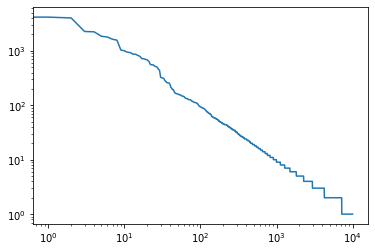

In [16]:
C = read_gutenberg("moby.txt")
common = count_voc(C).most_common(10000)
loglog([c[1] for c in common_cel])

Notese que se esta gráficando en una escala log-log

## Ejemplo para libros en español

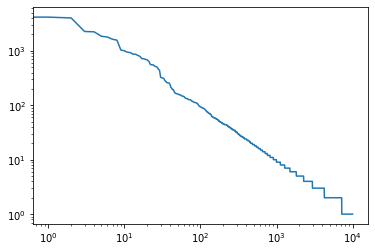

In [13]:
C = read_gutenberg("celestina.txt")
common = count_voc(C).most_common(10000)
loglog([c[1] for c in common_cel])

## Calculando los parámetros de la distribución a partir de pequeña muestra de los datos

[    1     2     3 ...  9998  9999 10000]
[14506  6704  6408 ...     2     2     2]
[  -38.06640076 14506.00000321] [inf inf]


/Users/sadit/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:795: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


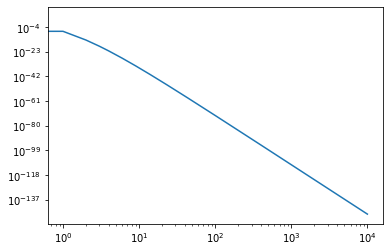

In [17]:
from scipy.optimize import curve_fit
import numpy as np

rank = np.array(range(1, len(common)+1))

def zipf(rank, a, b):
    p = b * (rank ** a)
    return p

freq = np.array([c[1] for c in common])
#freq.shape = (1, -1)
print(rank)
print(freq)
params, pcov = curve_fit(zipf, rank[:100], freq[:100])
perr = np.sqrt(np.diag(pcov))
print(params, perr)

loglog(zipf(rank, *params))

# Ley de Heaps
Es una ley que describe como crece el vocabulario con respecto al tamaño del texto de entrada

$\sigma \simeq n^\beta$, $0 < \beta < 1$

## Ejemplo ley de Heaps en inglés

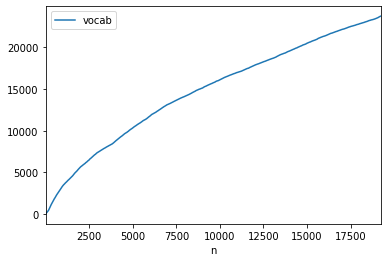

In [18]:
moby = read_gutenberg("moby.txt")
hmoby = heaps(moby)
hmoby.plot(x='n', y='vocab')

## Ejemplo ley de Heaps en español

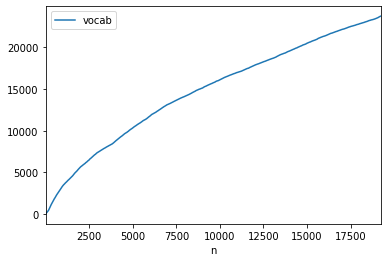

In [19]:
hcel = heaps(C)
hcel.plot(x='n', y='vocab')

## Ejercicios

Calcule los parametros de Zipf y Heaps, tanto para los libros `celistina.txt` como `moby.txt`; grafique